# Optical Character Recognition (OCR) with OpenVINO

This tutorial demonstrates how to perform optical character recognition (OCR) with OpenVINO models. It is a continuation of the [004-hello-detection](../004-hello-detection/004-hello-detection.ipynb) tutorial, which shows only text detection.

The [horizontal-text-detection-0001](https://docs.openvino.ai/latest/omz_models_model_horizontal_text_detection_0001.html) and [text-recognition-resnet](https://docs.openvino.ai/latest/omz_models_model_text_recognition_resnet_fc.html) models are used together for text detection and then text recognition.

In this tutorial, Open Model Zoo tools including Model Downloader, Model Converter and Info Dumper are used to download and convert the models from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo). See the [104-model-tools](../104-model-tools/104-model-tools.ipynb) tutorial for more information about these tools.

## Imports

In [11]:
import shutil
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
from PIL import Image
from openvino.runtime import Core
from yaspin import yaspin

sys.path.append("../utils")
from notebook_utils import load_image

## Settings

In [3]:
ie = Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"
base_model_dir = Path("~/open_model_zoo_models").expanduser()
omz_cache_dir = Path("~/open_model_zoo_cache").expanduser()

model_dir.mkdir(exist_ok=True)

## Download Models

The next cells will run Open Model Zoo's Model Downloader to download the detection and recognition models. If the models have been downloaded before, they will not be downloaded again.

In [4]:
download_command = f"omz_downloader --name {detection_model},{recognition_model} --output_dir {base_model_dir} --cache_dir {omz_cache_dir} --precision {precision}"
display(Markdown(f"Download command: `{download_command}`"))
with yaspin(text=f"Downloading {detection_model}, {recognition_model}") as sp:
    download_result = !$download_command
    print(download_result)
    sp.text = f"Finished downloading {detection_model}, {recognition_model}"
    sp.ok("✔")

Download command: `omz_downloader --name horizontal-text-detection-0001,text-recognition-resnet-fc --output_dir /home/dnth/open_model_zoo_models --cache_dir /home/dnth/open_model_zoo_cache --precision FP16`

⠏ Downloading horizontal-text-detection-0001, text-recognition-resnet-fc['################|| Downloading horizontal-text-detection-0001 ||################', '', '========== Downloading /home/dnth/open_model_zoo_models/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml', '... 100%, 956 KB, 837 KB/s, 1 seconds passed', '', '========== Downloading /home/dnth/open_model_zoo_models/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.bin', '... 27%, 1024 KB, 1801 KB/s, 0 seconds passed', '... 54%, 2048 KB, 1848 KB/s, 1 seconds passed', '... 81%, 3072 KB, 1880 KB/s, 1 seconds passed', '... 100%, 3786 KB, 1862 KB/s, 2 seconds passed', '', '################|| Downloading text-recognition-resnet-fc ||################', '', '========== Downloading /home/dnth/open_model_zoo_models/public/text-recognition-resnet-fc/vedastr/models/__init__.py', '... 100%, 0 KB, 109 KB/s, 0 seconds passed', '', '========== Downloading /home/dnth/open_model_zoo_models/pub

In [ ]:
### The text-recognition-resnet-fc model consists of many files. All filenames are printed in
### Model Downloader's output. Uncomment the next two lines to show this output

# for line in download_result:
#    print(line)

## Convert Models

The downloaded detection model is an Intel model, which is already in OpenVINO's Intermediate Representation (IR) format. The text recognition model is a public model which needs to be converted to IR. Since this model was downloaded from Open Model Zoo we can use Model Converter to convert the model to IR format.

Model Converter output will be displayed. Conversion was succesful if the last lines of output include `[ SUCCESS ] Generated IR version 11 model.`

In [5]:
convert_command = f"omz_converter --name {recognition_model} --precisions {precision} --download_dir {base_model_dir} --output_dir {base_model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {recognition_model}..."))
! $convert_command

Convert command: `omz_converter --name text-recognition-resnet-fc --precisions FP16 --download_dir /home/dnth/open_model_zoo_models --output_dir /home/dnth/open_model_zoo_models`

Converting text-recognition-resnet-fc...

========== Converting text-recognition-resnet-fc to ONNX
Conversion to ONNX command: /home/dnth/anaconda3/envs/alpr-teras/bin/python -- /home/dnth/anaconda3/envs/alpr-teras/lib/python3.8/site-packages/openvino/model_zoo/internal_scripts/pytorch_to_onnx.py --model-path=/home/dnth/anaconda3/envs/alpr-teras/lib/python3.8/site-packages/openvino/model_zoo/models/public/text-recognition-resnet-fc --model-path=/home/dnth/open_model_zoo_models/public/text-recognition-resnet-fc --model-name=get_model --import-module=model '--model-param=file_config=r"/home/dnth/open_model_zoo_models/public/text-recognition-resnet-fc/vedastr/configs/resnet_fc.py"' '--model-param=weights=r"/home/dnth/open_model_zoo_models/public/text-recognition-resnet-fc/vedastr/ckpt/resnet_fc.pth"' --input-shape=1,1,32,100 --input-names=input --output-names=output --output-file=/home/dnth/open_model_zoo_models/public/text-recognition-resnet-fc/resnet_fc.onnx

ONNX check passed successfully.

========== Converting text-recogniti

## Copy Models

To make it easier to work with the models, we copy the models from the Open Model Zoo tree to the _model_ subdirectory relative to this Jupyter notebook. We get the path to the Open Model Zoo model directory from Open Model Zoo's `omz_info_dumper` tool.

In [6]:
models_info_output = %sx omz_info_dumper --name $detection_model,$recognition_model
print(f'sx omz_info_dumper --name {detection_model},{recognition_model}')
detection_model_info, recognition_model_info = [
    {
        "name": "horizontal-text-detection-0001",
        "composite_model_name": None,
        "description": "Horizontal text detector based on FCOS with light MobileNetV2 backbone",
        "framework": "dldt",
        "license_url": "https://raw.githubusercontent.com/openvinotoolkit/open_model_zoo/master/LICENSE",
        "precisions": [
            "FP16",
            "FP16-INT8",
            "FP32"
        ],
        "quantization_output_precisions": [],
        "subdirectory": "intel/horizontal-text-detection-0001",
        "task_type": "detection"
    },
    {
        "name": "text-recognition-resnet-fc",
        "composite_model_name": None,
        "description": "\"text-recognition-resnet-fc\" is a simple and preformant scene text recognition model based on ResNet with Fully Connected text recognition head. Source implementation on a PyTorch* framework could be found here <https://github.com/Media-Smart/vedastr>. Model is able to recognize alphanumeric text.",
        "framework": "pytorch",
        "license_url": "https://raw.githubusercontent.com/Media-Smart/vedastr/0fd2a0bd7819ae4daa2a161501e9f1c2ac67e96a/LICENSE",
        "precisions": [
            "FP16",
            "FP32"
        ],
        "quantization_output_precisions": [],
        "subdirectory": "public/text-recognition-resnet-fc",
        "task_type": "optical_character_recognition"
    }
]

for model_info in (detection_model_info, recognition_model_info):
    omz_dir = Path(model_info["subdirectory"])
    omz_model_dir = base_model_dir / omz_dir / precision
    print(omz_model_dir) 
    for model_file in omz_model_dir.iterdir():
        try:
            shutil.copyfile(model_file, model_dir / model_file.name)
        except FileExistsError:
            pass

detection_model_path = (model_dir / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / recognition_model).with_suffix(".xml")

sx omz_info_dumper --name horizontal-text-detection-0001,text-recognition-resnet-fc
/home/dnth/open_model_zoo_models/intel/horizontal-text-detection-0001/FP16
/home/dnth/open_model_zoo_models/public/text-recognition-resnet-fc/FP16


## Object Detection

Load the detection model, load an image, do inference and get the detection inference result.

### Load Detection Model

In [7]:
detection_model = ie.read_model(
    model=detection_model_path, weights=detection_model_path.with_suffix(".bin")
)
detection_compiled_model = ie.compile_model(model=detection_model, device_name="CPU")

detection_input_layer = detection_compiled_model.input(0)

### Load an Image

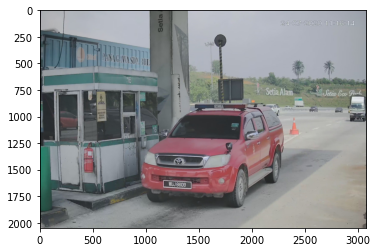

In [20]:
# image_file can point to a URL or local image
# image_file = "https://github.com/openvinotoolkit/openvino_notebooks/raw/main/notebooks/004-hello-detection/data/intel_rnb.jpg"

image_file = "sample_plate_imgs/244_M01_suv_police_68.jpg"
image = load_image(image_file)

# N,C,H,W = batch size, number of channels, height, width
N, C, H, W = detection_input_layer.shape

# Resize image to meet network expected input sizes
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

### Do Inference

Text boxes are detected in the images and returned as blobs of data in the shape of `[100, 5]`. Each detection description has the format `[x_min, y_min, x_max, y_max, conf]`.

In [21]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes
boxes = boxes[~np.all(boxes == 0, axis=1)]

### Get Detection Results

In [22]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [
        max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x
        for idx, shape in enumerate(box[:-1])
    ]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert base image from bgr to rgb format
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes
    for box, annotation in boxes:
        # Pick confidence factor from last place in array
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw box based on position, parameters in rectangle function are: image, start_point, end_point, color, thickness
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to image based on position and confidence, parameters in putText function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create background box based on annotation length
                (text_w, text_h), _ = cv2.getTextSize(
                    f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1
                )
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under text
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

## Text Recogntion

Load the text recognition model and do inference on the detected boxes from the detection model.

### Load Text Recognition Model

In [29]:
recognition_model = ie.read_model(
    model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin")
)

recognition_compiled_model = ie.compile_model(model=recognition_model, device_name="CPU")

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get height and width of input layer
_, _, H, W = recognition_input_layer.shape

### Do Inference

In [31]:
# Calculate scale for image resizing
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert image to grayscale for text recognition model
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get dictionary to encode output, based on model documentation
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"
# letters = "~0123456789abcdefghjklmnpqrstuvwxyz"

# Prepare empty list for annotations
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# For each crop, based on boxes given by detection model we want to get annotations
for i, crop in enumerate(boxes):
    # Get coordinates on corners of crop
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with recognition model
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze output to remove unnececery dimension
    recognition_results_test = np.squeeze(result)

    # Read annotation based on probabilities from output layer
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from argmax signalises end of string
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

## Show Results

### Show Detected Text Boxes and OCR Results for the Image

Visualize the result by drawing boxes around recognized text and showing the OCR result from the text recognition model

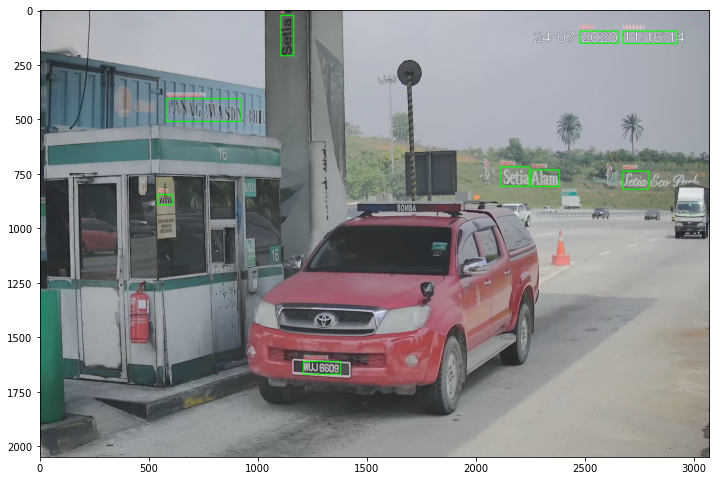

In [25]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True));

### Show the OCR Result per Bounding Box

Depending on the image, the OCR result may not be readable in the image with boxes as displayed in the cell above. In the next cell, we show the extracted boxes, and the OCR result per box.

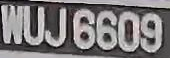

wuje6od

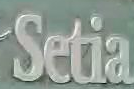

setia

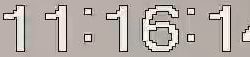

111111

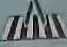

the

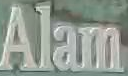

alam

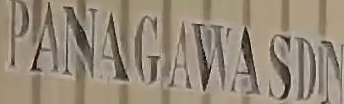

panaganasdy

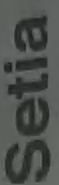

s

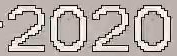

2020

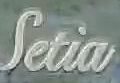

setia

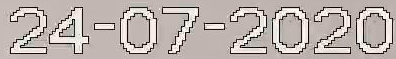

24072000

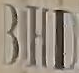

bhd

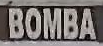

bomba

In [26]:
for cropped_image, annotation in zip(cropped_images, annotations):
    display(cropped_image, Markdown("".join(annotation)))

### Print Annotations in Plain Text Format

Print annotations for detected text based on their position in the input image starting from the upper left corner.


In [27]:
[
    annotation
    for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)
]

['panaganasdy',
 's',
 'bhd',
 'the',
 'bomba',
 '24072000',
 'setia',
 '2020',
 'alam',
 '111111',
 'wuje6od',
 'setia']